# Data aggregation

## Tesla edge

In [1]:
import pyspark
import pyspark.sql.functions as F
from pyspark.ml.stat import Correlation
from pyspark.sql.types import *
from datetime import datetime, timedelta
from pyspark.sql import Window
import time

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
utils = ["utilization_all", "utilization_tx", "utilization_rx_in_bss", "utilization_rx_other_bss", "utilization_unknown_wifi", "utilization_non_wifi"]
main_cols = ["org_name", "site_name", "ap_name", "band_rad", "bandwidth_rad"]
clients = ["median_active_client_rad", "max_active_client_rad", "avg_active_client_rad", "min_active_client_rad"]
reduce_names = ["med_clients", "max_clients", "avg_clients", "min_clients"]
test_cols = ["bcn_per_wlan", "noise_floor", "tx_phy_err", "mac_stats_tx_phy_err", "tx_errors", "rx_errors"]

# dt= "2022-06-13"
# dt= "2022-06-08"
# dt = "2022-06-16"
dt = "2022-06-22"
hr = "*"
site_id = '8cb91905-1843-4574-b7de-d2d0ae353cab'

In [6]:
df_org = spark.read.parquet("s3://mist-secorapp-production/dimension/org").select(F.col("id").alias("org_id"),F.col("name").alias("org_name")).persist()

df_name = spark.read.parquet("s3://mist-secorapp-production/dimension/site/site.parquet").select(F.col("id").alias("site_id"),F.col("name").alias("site_name"),F.col("org_id").alias("org_id")).join(df_org,["org_id"])\
.select("org_name","site_name","org_id","site_id").persist()

df_device_name = spark.read.parquet("s3://mist-secorapp-production/dimension/device")\
.select(F.col("mac").alias("ap_id"),F.col("name").alias("ap_name"),"site_id","model","type").persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# the roundTo unit is minutes
def roundTime(dt_in=None, roundTo=15):
    if not dt_in:
            return None
    if isinstance(dt_in,str):
        try:
            dt = datetime.strptime(dt_in[0:19].replace("T"," "), '%Y-%m-%d %H:%M:%S')
        except Exception as e:
            print(e)
            return None
    elif not isinstance(dt_in,datetime):
        return None
    else:
        dt = dt_in
    seconds = (dt- dt.min).seconds
    roundTo = roundTo*60
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)

def bcn_per_wlan(bcn, num_wlans, model=""):
    bcn = bcn if bcn != None else -1.0
    bcn_high = 700.0
    if model.find("AP41") > -1:
        bcn_norm = bcn if bcn < bcn_high else bcn_high
    else:
        bcn_norm = bcn / num_wlans if num_wlans > 0 else 0
    bcn_norm = bcn_norm if bcn_norm < bcn_high else bcn_high
    return float(bcn_norm)

bcn_per_wlan_norm = F.udf(bcn_per_wlan, FloatType())

def read_data(dt, hr):
    df = spark.read.parquet("s3://mist-secorapp-production/ap-stats-analytics/ap-stats-analytics-production/dt={dt}/hr={hr}".format(dt=dt,hr=hr)).persist()
    
    df = df.withColumn("radios", F.explode("radios"))\
            .select("ap_id", "site_id", "org_id", "model", "wlans",\
                F.col("radios.num_clients").alias("clients_rad"),\
                F.col("radios.num_active_clients").alias("active_clients_rad"), \
                F.col("radios.wlans").alias("wlans_rad"),\
                F.col("radios.channel").alias("channel"),\
                F.col("radios.noise_floor").alias("noise_floor"),\
                *[F.col(f"radios.{col}").alias(col) for col in utils],\
                F.col("radios.tx_phy_err").alias("tx_phy_err"),\
                F.col("radios.mac_stats_tx_phy_err").alias("mac_stats_tx_phy_err"),\
                F.col("radios.tx_errors").alias("tx_errors"),\
                F.col("radios.rx_errors").alias("rx_errors"),\
                F.col("radios.band").alias("band_rad"),\
                F.col("radios.bandwidth").alias("bandwidth_rad"),\
                F.col("radios.interrupt_stats_tx_bcn_succ").alias("interrupt_stats_tx_bcn_succ"),\
                F.to_timestamp(F.col("when")/1000000).alias("timestamp"))\
                .withColumn("num_wlans", F.size("wlans"))\
                .withColumn("bcn_per_wlan", bcn_per_wlan_norm(F.col("interrupt_stats_tx_bcn_succ"), F.col("num_wlans"), F.col("model")))\
                .where(F.col("bandwidth_rad") != 0)\
                .filter((F.size("wlans") > 0) & (F.col("radios.radio_missing")==False) & (F.col("uptime") > 24*60*60)).sort("band_rad")
    
    return df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def filtering_data(df, site_id):
    df_filter = df.withColumn("wlans", F.explode("wlans")).select("*", F.col("wlans.num_clients").alias("num_clients_wlans"),\
                F.col("wlans.radio_index").alias("radio_index_wlans"),\
                F.col("wlans.id").alias("id_wlans")).drop("wlans")
    
    # # add org_id, site_id, org_name, site_name, channel name, and ap_name.
    roundTimeUDF = F.udf(roundTime,TimestampType())
    df_filter = df_filter.filter(F.col("site_id") == site_id).withColumn("time",roundTimeUDF("timestamp"))\
                .groupby("org_id", "site_id", "ap_id", "band_rad", "bandwidth_rad", "wlans_rad", *(test_cols + utils))\
                .agg(F.first("active_clients_rad").alias("active_clients_rad"),\
                F.first("time").alias("time"),\
                F.first("channel").alias("channel"),\
                F.mean("active_clients_rad").alias("avg_active_client_rad"),\
                F.max("active_clients_rad").alias("max_active_client_rad"),\
                F.min("active_clients_rad").alias("min_active_client_rad"),\
                F.percentile_approx("active_clients_rad", 0.5).alias("median_active_client_rad"),\
                F.stddev("active_clients_rad").alias("std_active_client_rad")).withColumn("ap_id", F.regexp_replace("ap_id", "-", "")).withColumn("time", F.from_utc_timestamp('time', 'PST'))
    
    return df_filter

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# join everything in here
def change_id_to_names(df, df_name=df_name, df_device_name=df_device_name, df_org=df_org):
    shown_cols = main_cols[3:] + ["time"] + utils + test_cols
    df_get_names = df.alias("m").join(df_device_name.alias("ap"), \
            (F.col("m.ap_id") == F.col("ap.ap_id")) & (F.col("m.site_id") == F.col("ap.site_id")), "inner")\
            .join(df_name.alias("og_st"), \
            (F.col("m.org_id") == F.col("og_st.org_id")) & (F.col("m.site_id") == F.col("og_st.site_id")), "inner")\
            .select(F.col("og_st.org_name"), F.col("og_st.site_name"), F.col("ap.ap_name"), F.col("model"), F.col("time"), \
                *[F.col(f"m.{clients[i]}").alias(reduce_names[i]) for i in range(4)], *[f"m.{col}" for col in shown_cols]).distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
df_read = read_data(dt, hr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
df_filter = filtering_data(df_filter, site_id)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df_get_names = change_id_to_names(df_filter, site_id)

### Determine information about the APs

In [9]:
df_showcase = df_get_names.groupby(*main_cols)\
        .agg(F.min("time").alias("start_time"), F.max("time").alias("end_time"),
            F.round(F.max(reduce_names[1]), 2).alias(reduce_names[1]),\
             F.round(F.avg(reduce_names[2]), 2).alias(reduce_names[2]),\
            F.round(F.min(reduce_names[3]), 2).alias(reduce_names[3]),\
        *[F.round(F.max(F.col(util)), 2).alias("max_" + util) for util in utils], \
        *[F.round(F.min(F.col(util)), 2).alias("min_" + util) for util in utils],\
        *[F.round(F.avg(F.col(util)), 2).alias("avg_" + util) for util in utils]).sort(*main_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df_result = df_showcase.select(*main_cols, F.col("start_time"), F.col("end_time"),\
                                           *[F.struct(F.col("max_" + util), \
                                            F.col("avg_" + util), \
                                            F.col("min_" + util)).alias(util) for util in utils + ["clients"]])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df_result_band_24 = df_result.filter(F.col("band_rad") == 24)
df_result_band_24_v = df_showcase.filter(F.col("band_rad") == 24)

df_result_band_5 = df_result.filter(F.col("band_rad") == 5)
df_result_band_5_v = df_showcase.filter(F.col("band_rad") == 5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_result_band_24.show(df_result_band_24.count(), truncate = False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+---------------+--------+-------------+-------------------+-------------------+------------------+------------------+---------------------+------------------------+------------------------+--------------------+-------------+
|org_name|site_name|ap_name        |band_rad|bandwidth_rad|start_time         |end_time           |utilization_all   |utilization_tx    |utilization_rx_in_bss|utilization_rx_other_bss|utilization_unknown_wifi|utilization_non_wifi|clients      |
+--------+---------+---------------+--------+-------------+-------------------+-------------------+------------------+------------------+---------------------+------------------------+------------------------+--------------------+-------------+
|Tesla   |AUS07-GA |MIST-1C30-AP47 |24      |20           |2022-06-21 17:00:00|2022-06-22 17:00:00|{0.7, 0.26, 0.12} |{0.52, 0.04, 0.02}|{0.13, 0.0, 0.0}     |{0.17, 0.08, 0.02}      |{0.14, 0.05, 0.01}      |{0.3, 0.09, 0.02}   |{10, 2.98, 0}|
|Tesla   |AUS07-GA |

In [13]:
df_result_band_5.show(df_result_band_5.count(), truncate = False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+---------------+--------+-------------+-------------------+-------------------+------------------+------------------+---------------------+------------------------+------------------------+--------------------+--------------+
|org_name|site_name|ap_name        |band_rad|bandwidth_rad|start_time         |end_time           |utilization_all   |utilization_tx    |utilization_rx_in_bss|utilization_rx_other_bss|utilization_unknown_wifi|utilization_non_wifi|clients       |
+--------+---------+---------------+--------+-------------+-------------------+-------------------+------------------+------------------+---------------------+------------------------+------------------------+--------------------+--------------+
|Tesla   |AUS07-GA |MIST-1C30-AP44 |5       |20           |2022-06-21 17:00:00|2022-06-22 17:00:00|{0.89, 0.48, 0.0} |{0.8, 0.34, 0.0}  |{0.37, 0.05, 0.0}    |{0.44, 0.03, 0.0}       |{0.42, 0.06, 0.0}       |{0.01, 0.0, 0.0}    |{47, 15.34, 0}|
|Tesla   |AUS07-

In [14]:
%%spark -o df_result_band_24_v

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
%%spark -o df_result_band_5_v

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

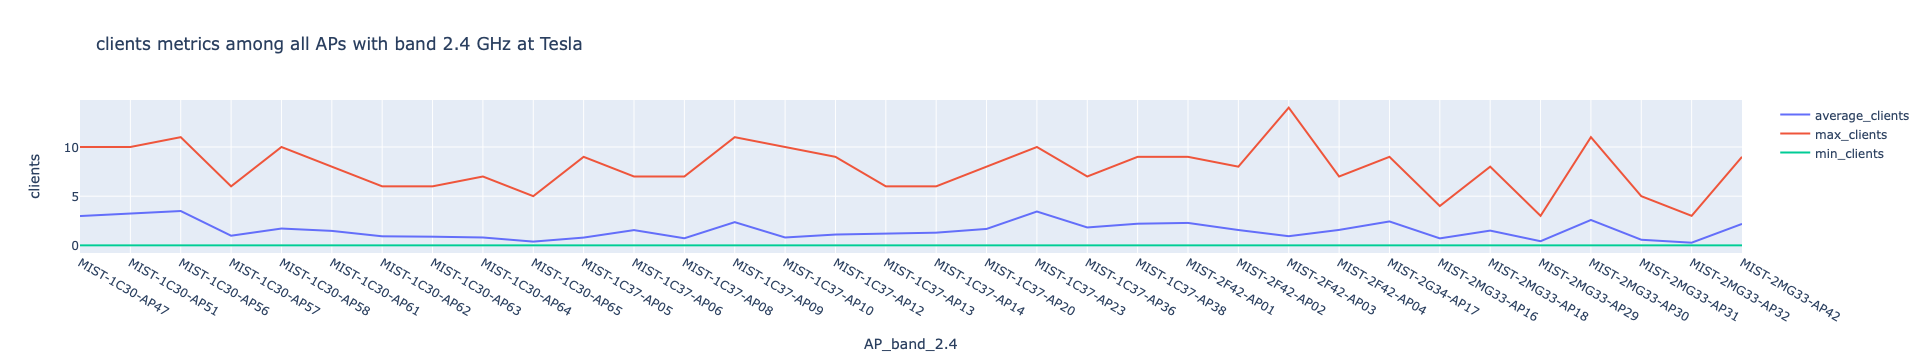

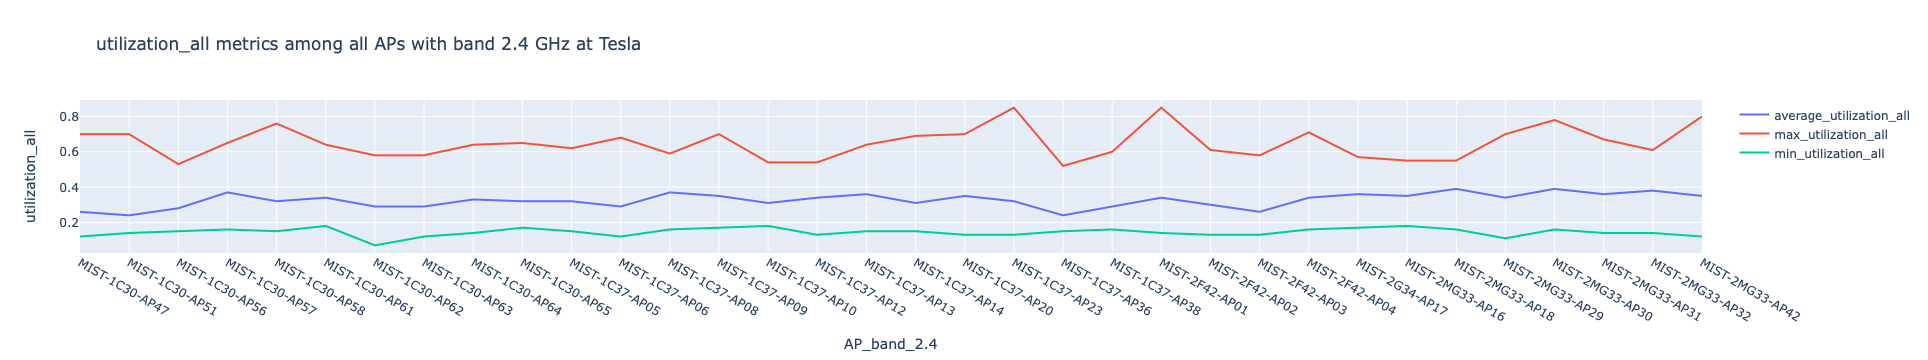

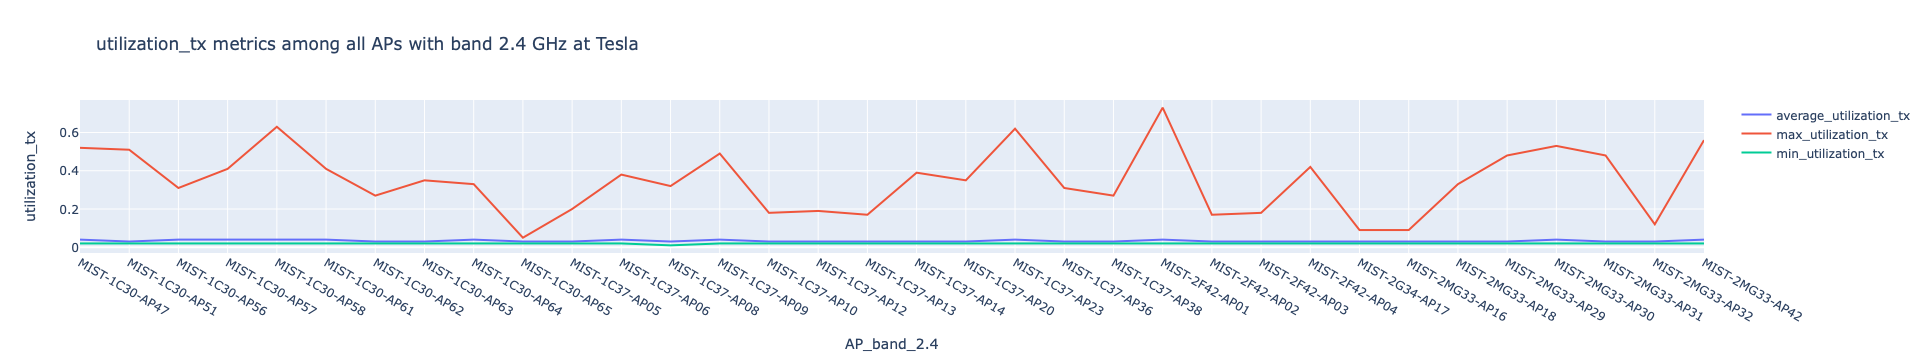

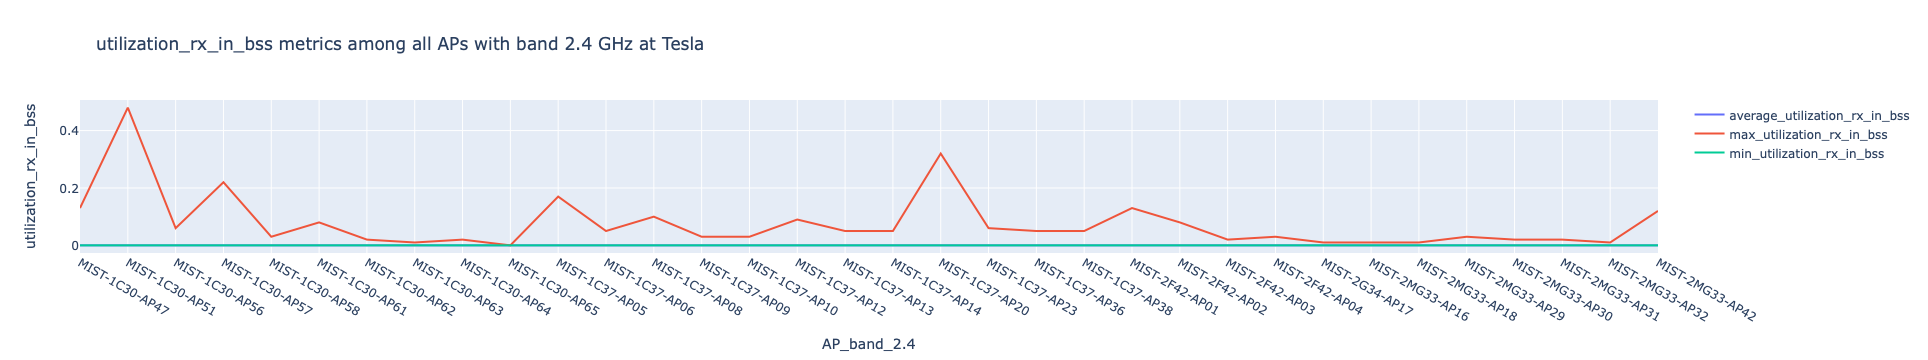

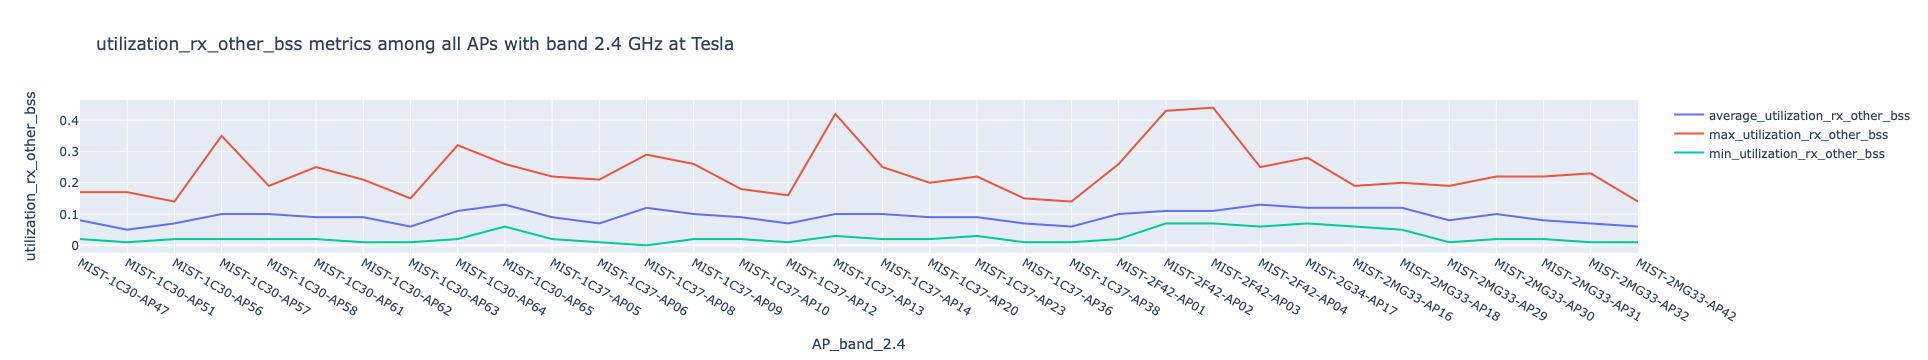

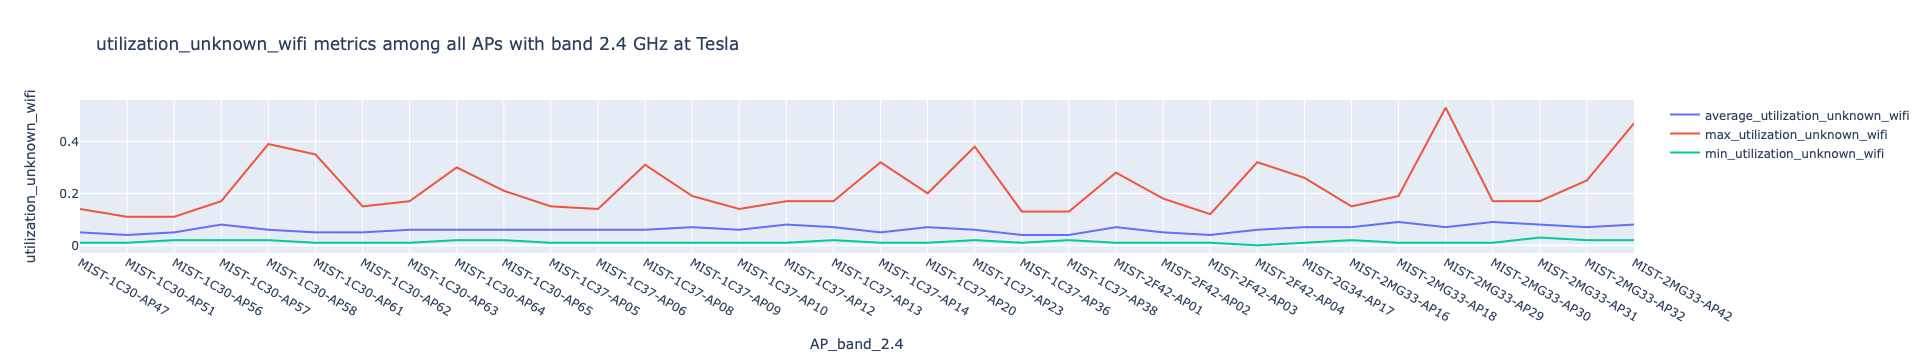

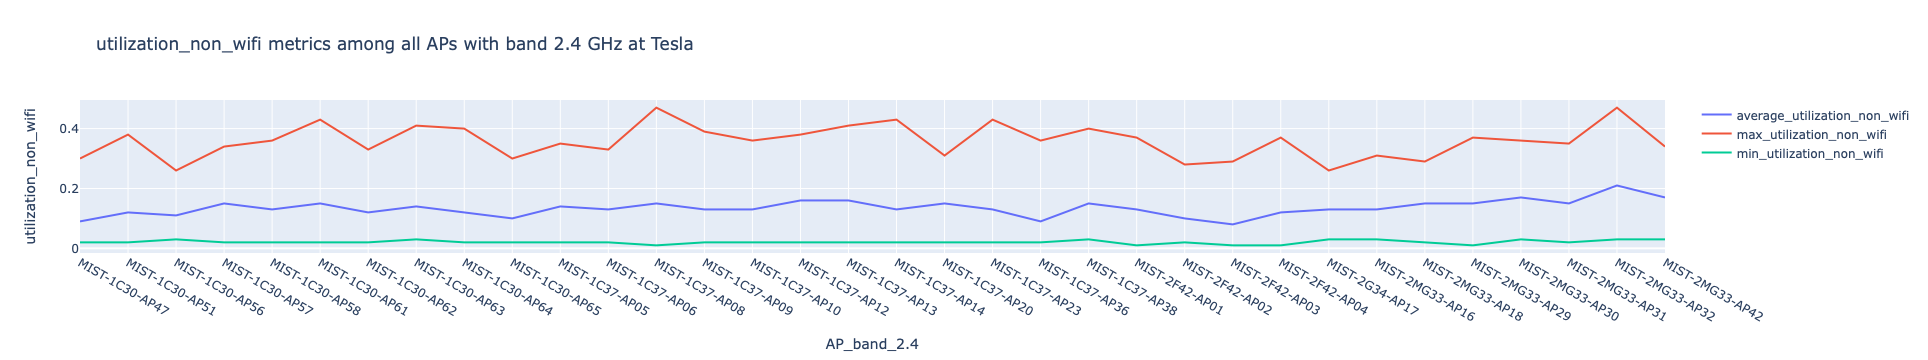

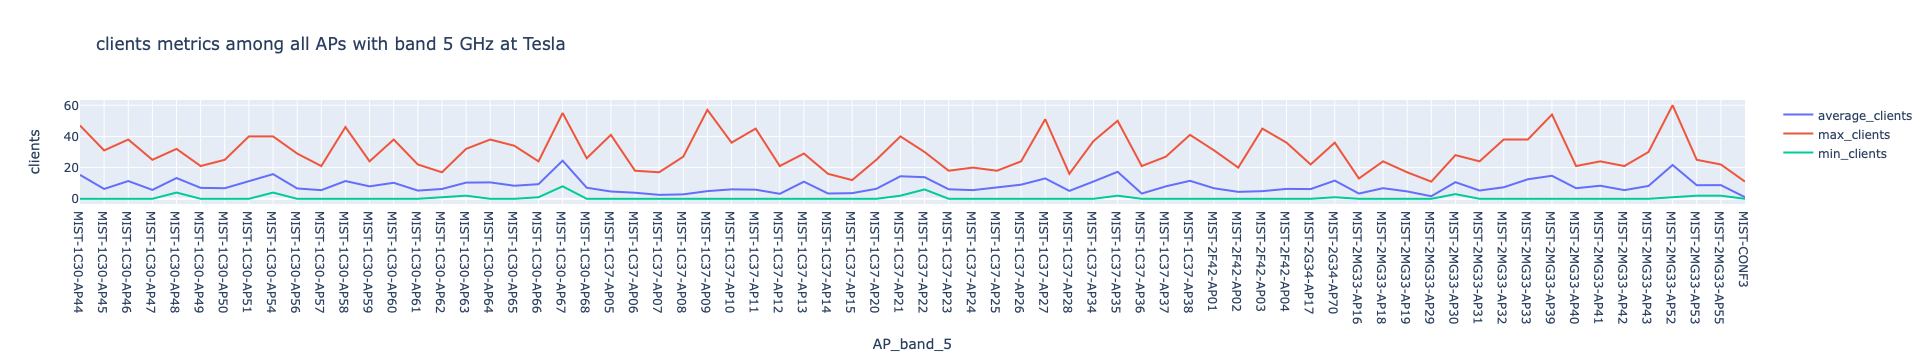

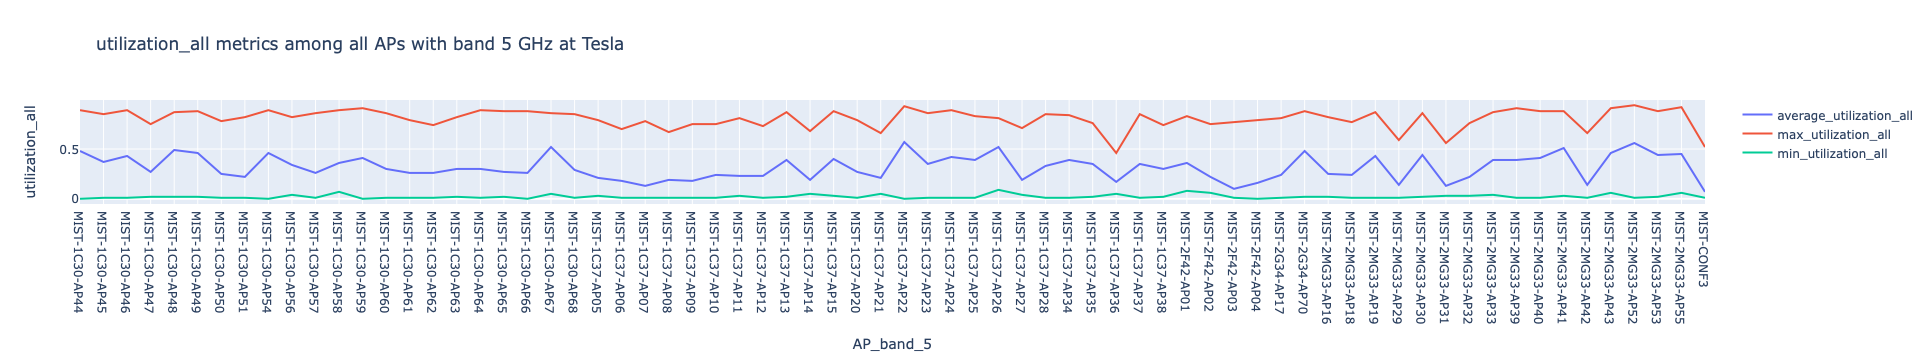

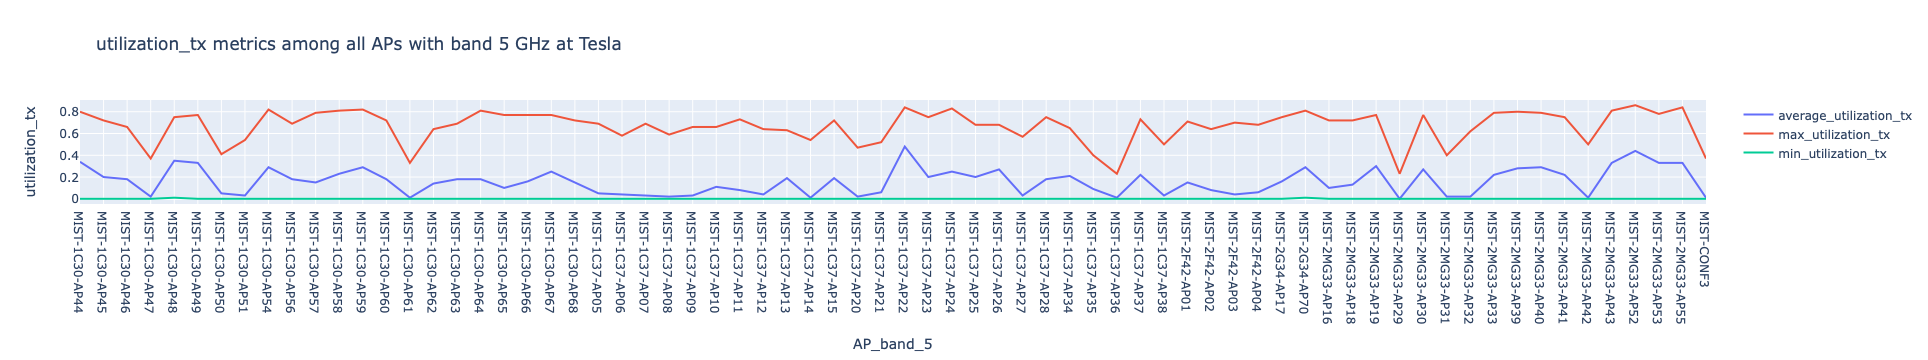

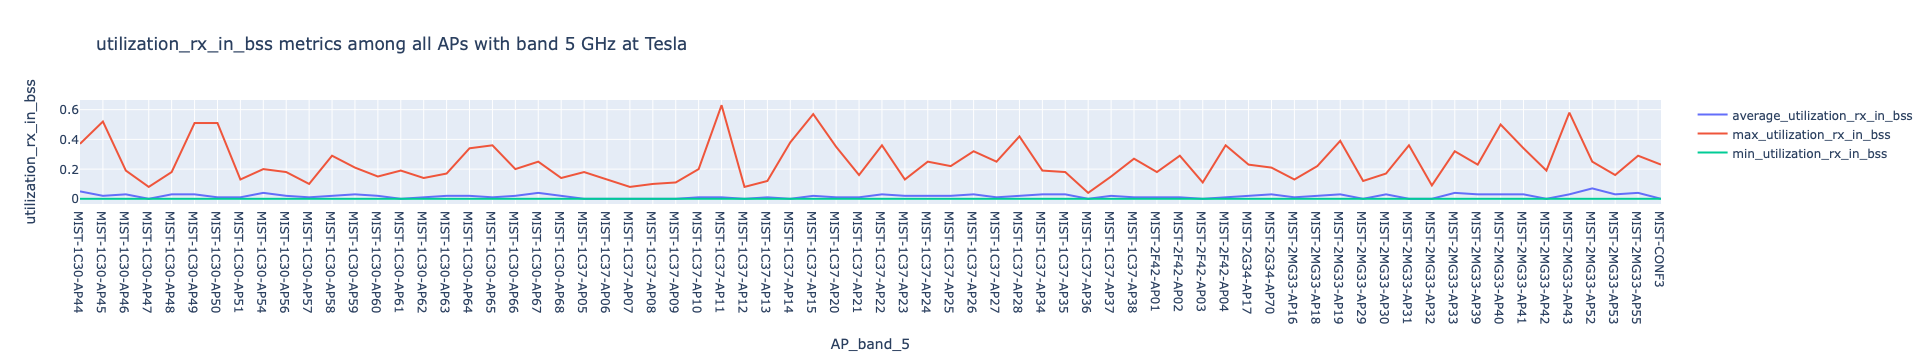

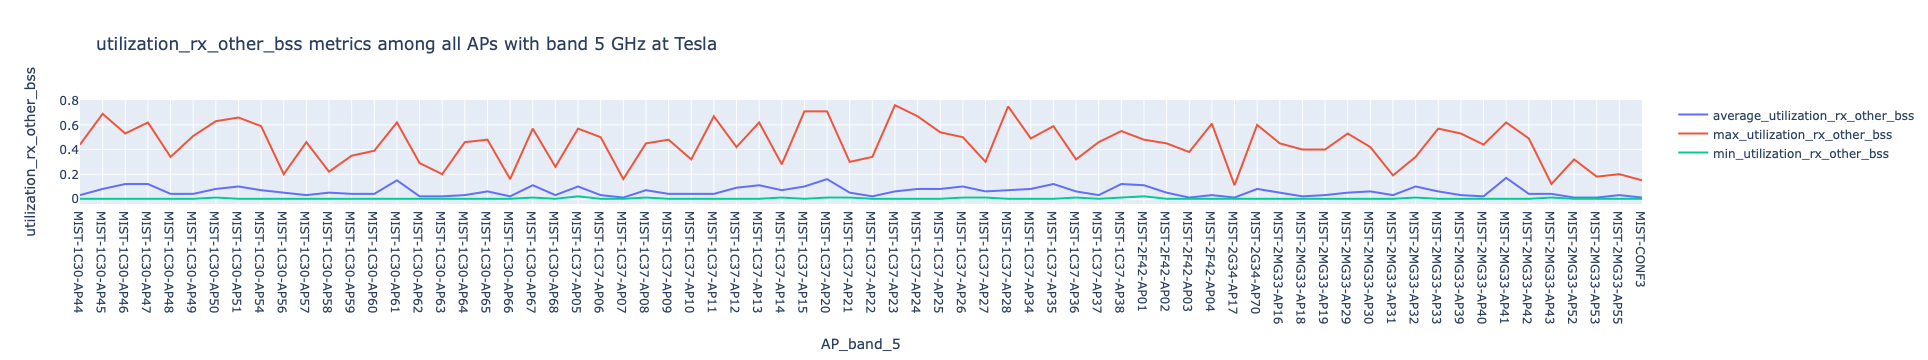

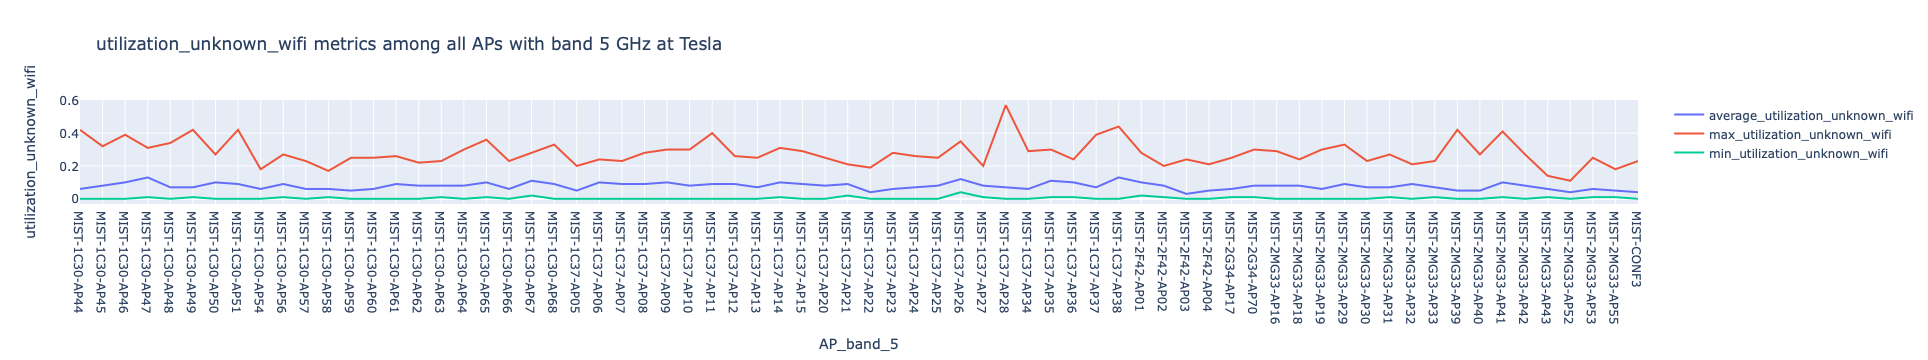

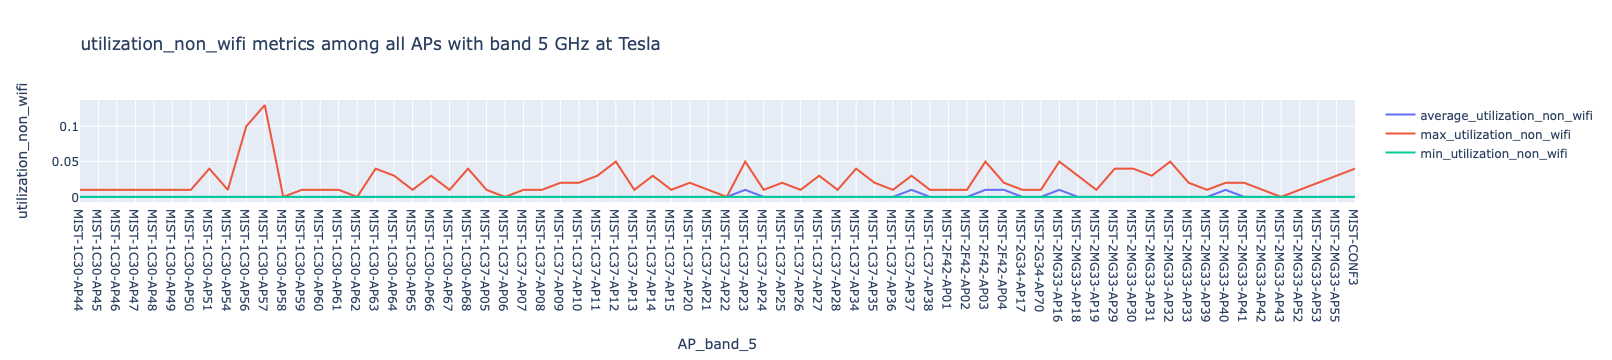

In [16]:
%%local
import plotly.graph_objects as go
import numpy as np

# f_cols = ["bcn_per_wlan", "noise_floor", "utilization_non_wifi", "tx_phy_err", "mac_stats_tx_phy_err", "tx_errors", "rx_errors"] + ["clients"] 
f_cols = ["clients"] + ["utilization_all", "utilization_tx", "utilization_rx_in_bss", "utilization_rx_other_bss", "utilization_unknown_wifi", "utilization_non_wifi"]

dfs = [df_result_band_24_v, df_result_band_5_v]
bands = [2.4, 5]

for i in range(len(dfs)):
    band = bands[i]
    df = dfs[i]
    for column in f_cols:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df["ap_name"], y= df[f"avg_{column}"], mode = 'lines', name =f'average_{column}'))
        fig.add_trace(go.Scatter(x=df["ap_name"], y= df[f"max_{column}"], mode = 'lines', name =f'max_{column}'))
        fig.add_trace(go.Scatter(x=df["ap_name"], y= df[f"min_{column}"], mode = 'lines', name =f'min_{column}'))
        fig.update_layout(xaxis_title= f"AP_band_{band}", yaxis_title = column, title = f"{column} metrics among all APs with band {band} GHz at Tesla")
        # The two histograms are drawn on top of another
        fig.show()

# Test the edge detection engineering

In [9]:
import time 
start = time.time()
detects = main_cols + ["time"]
w1 = Window.partitionBy(F.col("ap_name"), F.col("band_rad")).orderBy(F.col("time").desc())
shift = -1
thre_clients = 3

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
prevs = ["clients", "med_clients"]
df_get_names = df_get_names.withColumn("clients", F.col("avg_clients"))
df_drops = df_get_names.withColumn("clients", F.col("avg_clients")).select("*", *[F.lag(c, offset=shift).over(w1).alias("prev_" + c) for c in prevs])\
            .filter((F.col("med_clients") == 0) & ((F.col("prev_med_clients") > thre_clients)))\
            .filter((F.col("clients") == 0) & (F.col("prev_clients") > thre_clients))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
thresold = 45/15 
time_window = "45 minutes"
slide = "15 minutes"
w2 = F.window("time", windowDuration = time_window, slideDuration = slide)
df_edges = df_drops.groupby(*main_cols, w2)\
            .agg(F.avg("med_clients").alias("avg_median"),\
                 F.count("med_clients").alias("count_median"),\
                 F.max("med_clients").alias("max_median"),\
                 F.min("med_clients").alias("min_median"),\
                 F.avg("clients").alias("avg_clients"),\
                 F.first("time").alias("time"),)\
            .filter(F.col("window.start") == F.col("time"))\
            .filter(F.col("count_median") > thresold)\
            .filter((F.col("avg_median") == 0) & (F.col("avg_clients") == 0))\
            .select(*detects)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
df_edges.show(df_edges.count(), truncate = False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+---------------+--------+-------------+-------------------+
|org_name|site_name|ap_name        |band_rad|bandwidth_rad|time               |
+--------+---------+---------------+--------+-------------+-------------------+
|Tesla   |AUS07-GA |MIST-2MG33-AP43|5       |20           |2022-06-21 17:15:00|
+--------+---------+---------------+--------+-------------+-------------------+

In [35]:
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

600.3136560916901

In [36]:
collections = df_edges.select("ap_name", "band_rad", "time").toPandas().values.tolist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
collections

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[['MIST-1C30-AP57', '24', Timestamp('2022-06-22 10:00:00')]]

In [38]:
some_tests = ["zero_client", "bcn_per_wlan_drop", "noise_floor_high", "tx_phy_err_high", "utilization_non_wifi_high"]
df_aps = None
df_timeframes = None

for ap in collections:
    ap_name = ap[0]
    band_rad = ap[1]
    d_time = ap[2]
    df_ap = df_get_names.filter((F.col("ap_name") == ap_name) & (F.col("band_rad") == band_rad)).sort("ap_name", "band_rad", "time")
    if df_aps:
        df_aps = df_aps.union(df_ap)
    else:
        df_aps = df_ap
    
    df_timeframe = df_ap.filter((F.col("time")>= F.lit(d_time)) & (F.col("time") <= F.lit(d_time) + F.expr("INTERVAL 30 minutes")))
    
    if df_timeframes:
        df_timeframes = df_timeframes.union(df_timeframe)
    else:
        df_timeframes = df_timeframe
    df_timeframe.withColumn("bcn_per_wlan_drop", F.col("bcn_per_wlan")<500.0)\
        .withColumn("noise_floor_high", F.col("noise_floor")>-60.0) \
        .withColumn("tx_phy_err_high", F.col("tx_phy_err")>1.0) \
        .withColumn("zero_client", F.col("clients")== 0.0) \
        .withColumn("count", F.col("bcn_per_wlan"))\
        .withColumn("utilization_non_wifi_high", F.col("utilization_non_wifi")>0.30).select("time", *(some_tests), "count").show(df_timeframe.count(), truncate = False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-----------------+----------------+---------------+-------------------------+------+
|time               |zero_client|bcn_per_wlan_drop|noise_floor_high|tx_phy_err_high|utilization_non_wifi_high|count |
+-------------------+-----------+-----------------+----------------+---------------+-------------------------+------+
|2022-06-22 10:00:00|false      |true             |false           |false          |false                    |291.5 |
|2022-06-22 10:00:00|true       |true             |false           |false          |false                    |298.25|
|2022-06-22 10:00:00|false      |true             |false           |false          |false                    |297.75|
|2022-06-22 10:00:00|false      |true             |false           |false          |false                    |299.75|
|2022-06-22 10:00:00|false      |true             |false           |false          |false                    |290.5 |
|2022-06-22 10:00:00|true       |true             |false

In [42]:
%%spark -o df_aps

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
%%spark -o df_timeframes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

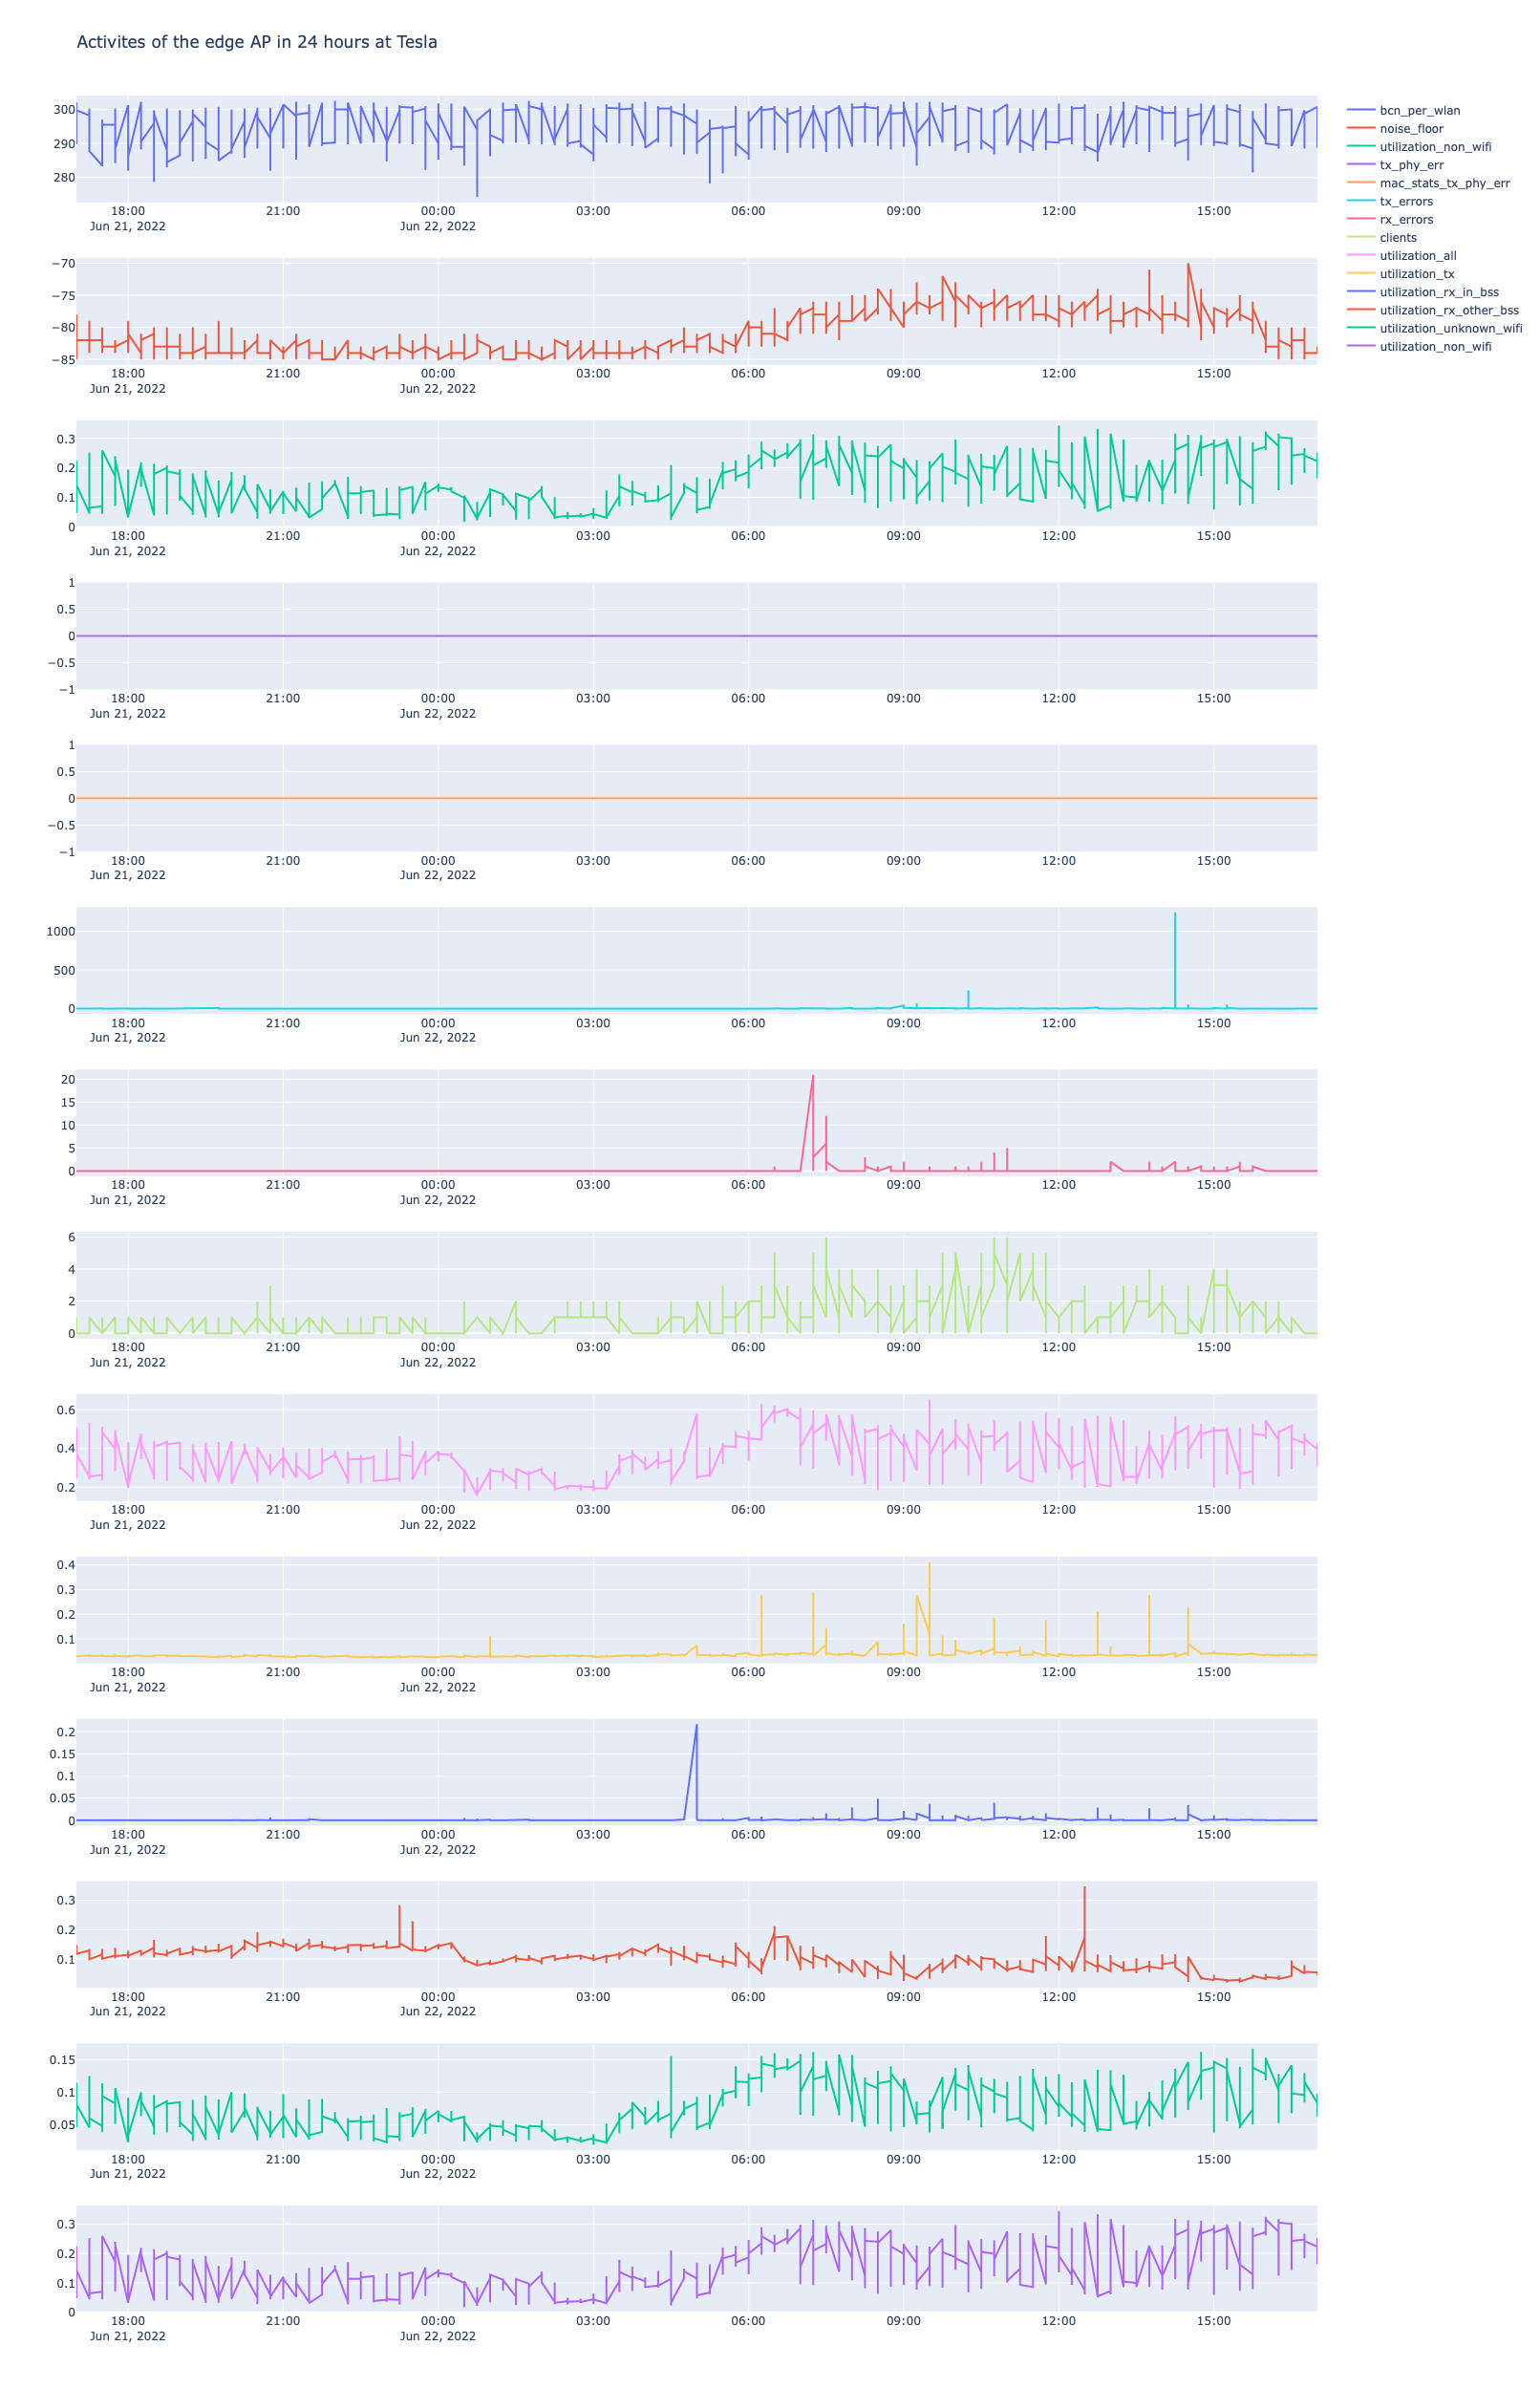

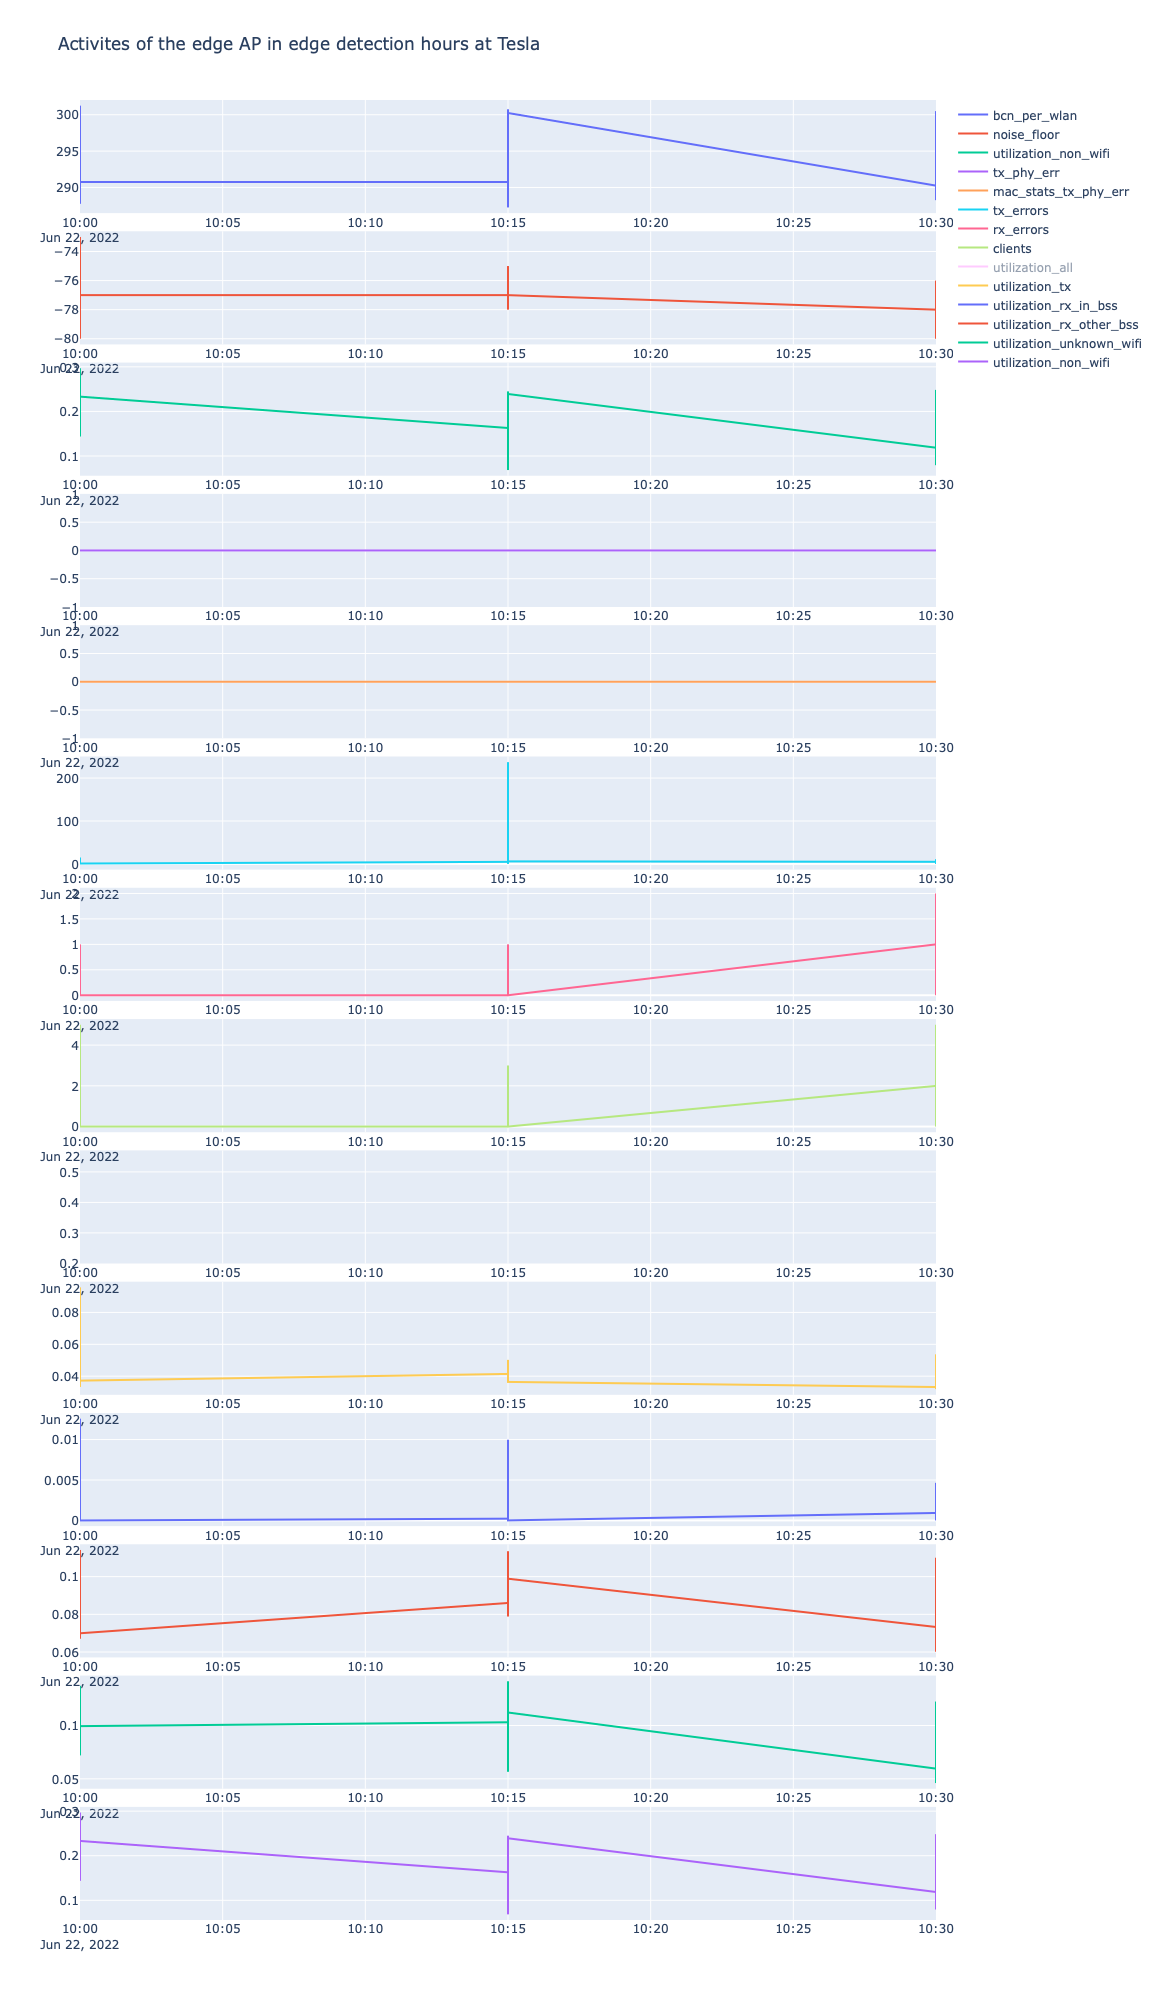

In [44]:
%%local
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

f_cols = ["bcn_per_wlan", "noise_floor", "utilization_non_wifi", "tx_phy_err", "mac_stats_tx_phy_err", "tx_errors", "rx_errors"] \
            + ["clients"] + ["utilization_all", "utilization_tx", "utilization_rx_in_bss", "utilization_rx_other_bss", \
            "utilization_unknown_wifi", "utilization_non_wifi"]

fig1 = make_subplots(rows=len(f_cols), cols=1, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.025)
for i, column in enumerate(f_cols):
    fig1.add_trace(go.Scatter(x=df_aps["time"], y= df_aps[column], mode = 'lines', name = column), row = i + 1, col = 1)
    fig1.update_xaxes(showticklabels=True, row=i+1, col=1)
fig1.update_layout(height=2500, width=1500, title = "Activites of the edge AP in 24 hours at Tesla")
fig1.show()

fig2 = make_subplots(rows=len(f_cols), cols=1, shared_xaxes=True, vertical_spacing=0.01)
for i, column in enumerate(f_cols):
    fig2.add_trace(go.Scatter(x=df_timeframes["time"], y= df_timeframes[column], mode = 'lines', name = column), row = i + 1, col = 1)
    fig2.update_xaxes(showticklabels=True, row=i+1, col=1)
fig2.update_layout(height=2000, width=1500, title = "Activites of the edge AP in edge detection hours at Tesla")
fig2.show()

In [ ]:
df_sort = df_id.filter(F.col("time") == F.lit(d_times[0]))
df_edges.select(*main_cols).show(truncate = False)
df_sort.select([F.struct(F.round(F.max(col), 2), F.round(F.avg(col), 2), F.round(F.min(col), 2)).alias(col) for col in test_cols]).show(truncate = False)
df_sort.select([F.struct(F.round(F.max(col), 2), F.round(F.avg(col), 2), F.round(F.min(col), 2)).alias(col) for col in utils]).show(truncate = False)

# Correlation test